<center>
<img src="img/ml_theme.png">
# Вводный курс по нейронным сетям
<center>
**Автор материала: программист-исследователь Mail.Ru Group  Юрий Кашницкий**

# <center>Часть 2. Алгоритм Backpropagation (начало). Простая нейронная сеть на данных MNIST
<center>Данный материал создан на базе стэнфордских курсов [cs231n](http://cs231n.stanford.edu) и ["Machine Learning"](https://www.coursera.org/learn/machine-learning)

## План 
 - Граф вычислений и backprop (на интуитивном уровне)
 - Задание на backprop в простом графе вычислений
 - Нейронная сеть для классификации изображений MNIST 

## Граф вычислений и backprop (на интуитивном уровне)

В прошлый раз мы говорили о softmax-классификаторе. В конечном счете все сводилось к минимизации некоторой функции потерь $L(W, X)$:

$\large L = \frac{1}{N} \sum_{i=1}^N \big( -f_{y_i} + \log \sum_{j=1}^Ke^{f_{j}}\big) + \lambda \sum_{k=1}^K \sum_{l=1}^D W^2_{k,l},$ <br>где $f = XW$

Чтобы делать это эффективно (градиентными методами), мы хотим знать $\nabla L$. Градиент можно считать аналитически, но уже даже для функции потерь softmax это не так тривиально. Тем более – делать это для сложных функций (глубоких сетей).


Альтернатива – просто *уметь вычислять* градиент. Для начала удобно представить вычисление $L$ в виде *графа вычислений*:

<img src='img/computational_graph_softmax.png'>

Суть алгоритма обратного распространения ошибки – в вычислении частных производных функции на выходе по переменным на входе. В основе всего – правило дифференцирования композиции функций. Рассмотрим пару простых примеров (разбор у доски) [отсюда](http://cs231n.github.io/optimization-2/) (картинки также из курса [cs231n](http://cs231n.github.io/)). Далее, после обучения первых сетей, будем обсуждать матричные вычисления и векторизованную версию backprop.



1. $f(x, y, z) = (x + y)\ z$

Нужно определить частные производные выхода $f$ по входам $x$, $y$ и $z$.

<img src='img/backprop_ex1.png'>

2\. Логистическая регрессия для двух входов (признаков)

$$f(\textbf{w}, \textbf{x}) = \sigma(\textbf{w}^T\textbf{x}) = \frac{1}{1 + e^{-(w_0x_0 + w_1x_1 + w_2)}}$$

Нужно определить частные производные выхода $f$ по входам $w_0$, $w_1$ и $w_2$.

<img src='img/backprop_ex2.png'>

## Задание на backprop в простом графе вычислений
1. $f(x, y, z) = x^2 - yz$

    1.1. Нарисуйте граф вычисления функции 
    
    1.2. Посчитайте с помощью графа значение функции для $(x, y, z) = (-2, 3, 1)$
    
    1.3. Посчитайте с помощью backprop значения частных производных $\frac{\partial{f}}{\partial{x}}, \frac{\partial{f}}{\partial{y}}$ и $\frac{\partial{f}}{\partial{z}}$ при <br> $(x, y, z) = (-2, 3, 1)$
    
    1.4. Выведите те же производные аналитически (дифференцируя $f(x, y, z) = x^2 - yz$), посчитайте в $(-2, 3, 1)$ и сравните со значениями, полученными на прошлом шаге

2\. Логистическая функция потерь $L = \ln{(1 + \exp^{-(w_0 + w_1x)})}$

   2.1. Нарисуйте граф вычисления функции 
    
   2.2. Посчитайте с помощью графа значение функции для $(w_0, w_1, x) = (-7, 4, 2)$
    
   2.3. Посчитайте с помощью backprop значения частных производных $\frac{\partial{f}}{\partial{w_0}}, \frac{\partial{f}}{\partial{w_1}}$ и $\frac{\partial{f}}{\partial{x}}$ при $(w_0, w_1, x) = (-7, 4, 2)$
    
   2.4. Выведите $\frac{\partial{f}}{\partial{w_0}}$ и $\frac{\partial{f}}{\partial{w_1}}$ аналитически, посчитайте для указанных значений переменных и сравните с предыдущим результатом



## Нейронная сеть для классификации изображений MNIST 
Эта часть – на базе задания [курса](https://www.coursera.org/learn/machine-learning) Andrew Ng "Machine Learning". Оригинальное задание #4 описано в [PDF-файле](https://github.com/Yorko/HSE_BigML_AddProfEduc/blob/master/module7_deep_learning/slides_materials/ng_ex4_backprop.pdf). 

In [1]:
import numpy as np
import scipy.io 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [2]:
data_dict = scipy.io.loadmat('data/mnist/mnist20x20.mat')
X = data_dict['X']
y = data_dict['y'].ravel()

5 тысяч картинок 20 x 20. $M$ – число картинок, 5000. $N$ – размерность, 400 чисел, т.к. картинки 20 x 20

In [3]:
M, N = X.shape
print(M, N)

5000 400


**Предобработка данных**
Добавляем слева к $X$ столбец из всех единиц – "фиктивная размерность"

In [4]:
X = np.hstack([np.ones((M, 1)), X])

сейчас $y$ – это вектор из 5000 меток классов. Применим One-Hot-Encoding и получим матрицу размерами $M \times K$, то есть $5000 \times 10$

In [5]:
y[:10], np.unique(y)

(array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=uint8),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8))

In [6]:
target_encoder = OneHotEncoder(sparse=False)
Y = target_encoder.fit_transform(y.reshape(-1, 1))
Y[:10,:]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [7]:
# Нарисуем, как выглядят картинки
def visualize_data(M, N, dim=10):
    num_pix = int(np.sqrt(N))
    fig = plt.figure(figsize=(5, 5))

    gs = gridspec.GridSpec(dim, dim)
    gs.update(bottom=0.01, top=0.99, left=0.01, right=0.99, 
          hspace=0.05, wspace=0.05)

    examples = X[:, 1:][np.random.randint(M, size=dim * dim)]
    k = 0
    for i in range(dim):
        for j in range(dim):
            ax = plt.subplot(gs[i, j])
            ax.axis('off')
            ax.imshow(examples[k].reshape(num_pix, num_pix).T,
                cmap=plt.get_cmap('Greys'), interpolation='nearest')
            k += 1

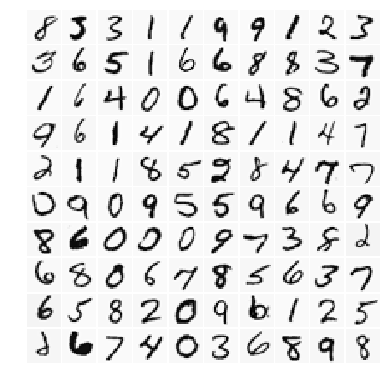

In [8]:
visualize_data(M, N)

Архитетура будущей сети: на входе 401 нейрон (400 признаков картинок 20 x 20 + фиктивный признак из всех единиц, "bias"). В скрытом слое будет 25 нейронов (вместе с "bias" $L$ = 26). На выходе $K$ = 10 нейронов по числу классов. 

<img src='img/ng_neural_network_mnist.png'>

In [9]:
L = 26
K = len(np.unique(y))

Матрицы параметров сети – это $\Theta_1$ размерности $(L - 1, M) = (25, 401)$ и $\Theta_2$ размерности $(K, L) = (10, 26)$. Первая из них отвечает за веса, связывающие каждый из 25-ти нейронов скрытого слоя с каждым из 401 нейрона входного слоя. Вторая – за веса, связывающие каждый из 10-ти нейронов выходного слоя с каждым из 26 нейронов скрытого слоя.

Инициализируем параметры сети малыми случайными числами из $(-\epsilon_{init}, \epsilon_{init})$

In [10]:
eps_init = 0.1
theta_1_0 = np.random.uniform(-eps_init, eps_init, size=(L - 1, N + 1))
theta_2_0 = np.random.uniform(-eps_init, eps_init, size = (K, L))

nn_params_0 = np.concatenate((theta_1_0.flatten(), theta_2_0.flatten()))

theta_1_0.shape, theta_2_0.shape, nn_params_0.shape

((25, 401), (10, 26), (10285,))

Реализуем функцию потерь. Без регуляризации она выглядит как знакомый нам по логистической регрессии log_loss, только
просуммированный по $K=10$ классам. 

$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\big[-y^{(i)}_{k}\, \log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,\log\,(1-h_\theta(x^{(i)}))_k)\big]$$

Здесь $h_\theta(x)$ – это сигмоида $\sigma(\theta^Tx) = \frac{1}{1 + \exp^{-\theta^Tx}}$

В случае регуляризации выражение будет чуть посложнее:

$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\bigg[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\bigg] + \frac{\lambda}{2m}\bigg[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j,k}^{(1)})^2+\sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j,k}^{(2)})^2\bigg]$$

In [11]:
# Определим сигмоиду и ее градиент
sigmoid = lambda x: 1 / (1 + np.exp(-x))
sigmoid_gradient = lambda x: sigmoid(x) * (1 - sigmoid(x))

def nn_cost_function_reg(nn_params, X, Y, M, N, L, K, lam):

    # Unroll the parameter vector.
    theta_1 = nn_params[:(L - 1) * (N + 1)].reshape(L - 1, N + 1)
    theta_2 = nn_params[(L - 1) * (N + 1):].reshape(K, L)
    
    # Calculate activations in the second layer.
    z_2 = theta_1.dot(X.T)
    a_2 = sigmoid(z_2)
    
    # Add the second layer's bias node.
    a_2_p = np.vstack((np.ones(M), a_2))
    
    # Calculate the activation of the third layer.
    z_3 = theta_2.dot(a_2_p)
    a_3 = sigmoid(z_3)
    
    # Calculate the cost function with the addition of a regularization term.
    cost = 1 / M * np.trace(- Y.dot(np.log(a_3)) - (1 - Y).dot(np.log(1 - a_3))) \
        + lam / 2 / M * (np.sum(theta_1[:, 1:] * theta_1[:, 1:]) \
                         + np.sum(theta_2[:, 1:] * theta_2[:, 1:]))
    
    cache = (theta_1, theta_2, z_2, a_2_p, z_3, a_3)
    return cost, cache

Алгоритм обратного распространения ошибки будет состоять из следующих шагов:

В цикле по объектам обучающей выборки ($t = 1 \ldots M$):

 - Устанавливаем активацию входного слоя $a^{(1)} = x^{(t)}$ просто как признаки входного примера
 - Считаем выход сети на примере $x^{(t)}$, запоминая активации $z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)}$. 
 - Для каждого из выходных нейронов считаем накопившуюся ошибку: $\delta_k^{(3)} = a_k^{(3)} - y_k$
 - Считаем ошибку в скрытом слое: $$\delta_k^{(2)} = (\Theta^{(2)})^T \delta^{(3)} * \sigma^\prime(z^{(2)})$$ где $\sigma^\prime(z) = \sigma(z) (1 - \sigma(z))$. Почему это так – вывод у доски, поможет [правило](http://cs231n.stanford.edu/handouts/linear-backprop.pdf) backprop через линейный слой, подробней об этом – позже (результат: если $Y = XW$, то $\frac{\partial{L}}{\partial{X}} = \frac{\partial{L}}{\partial{Y}}W^T$ и $\frac{\partial{L}}{\partial{W}} = X^T\frac{\partial{L}}{\partial{Y}}$)
 - Добавляем градиент от текущего примера к уже посчитанному градиенту: $$\Delta^{(l)} \leftarrow \Delta^{(l)}  + \delta^{(l+1)}(a^{(l)})^T$$
 - Считаем градиенты функции потерь по всем весам: $$\frac{\partial}{\partial\Theta_{ij}^{(l)}}L(\Theta) = \frac{1}{m}\Delta_{ij}^{(l)}$$

In [12]:
def nn_cost_function_grad_reg(nn_params, X, Y, M, N, L, K, lam):   
    
    cost, cache = nn_cost_function_reg(nn_params, X, Y, M, N, L, K, lam)
    theta_1, theta_2, z_2, a_2_p, z_3, a_3 = cache
    
    
    """Backpropagation (use the chain rule)."""
    # Calculate the gradient for parameters in the third layer.
    grad_theta_2 = 1 / M * (a_3 - Y.T).dot(a_2_p.T) \
    # this is the theta_2 grad reg term
    + lam / M * np.hstack((np.zeros(K).reshape(-1,1), theta_2[:, 1:])) 
    
    # Calculate the gradient for parameters in the second layer.
    theta_delta = theta_2_0[:, 1:].T.dot(a_3 - Y.T)
    d_z_2 = sigmoid_gradient(z_2)
    grad_theta_1 = 1 / M * np.array([[np.sum(theta_delta[p] * d_z_2[p] * X.T[q]) 
        for q in range(N + 1)] for p in range(L - 1)]) \
    # this is the theta_1 grad reg term
    + lam / M * np.hstack((np.zeros(L - 1).reshape(-1, 1), theta_1[:, 1:])) 
    
    # Roll the two gradient vectors into a single vector.
    grad = np.concatenate((grad_theta_1.flatten(), grad_theta_2.flatten()))  
    
    cost_history.append(cost)
    return cost, grad

In [13]:
%%time
lam = 1
# Use this array to log costs calculated in the call to scipy's "minimize" below.
cost_history = []

res = minimize(nn_cost_function_grad_reg, nn_params_0, 
               method='L-BFGS-B', args=(X, Y, M, N, L, K, lam), 
               jac=True, options={'maxiter': 100})

CPU times: user 2min 11s, sys: 39.5 s, total: 2min 51s
Wall time: 1min 31s


(0, 7.3786281384182271)

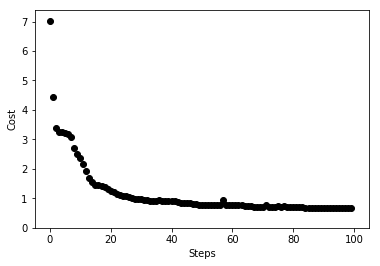

In [14]:
num_steps = 100

# Нарисуем кривую обучения
plt.figure()
plt.scatter(np.arange(num_steps), np.array(cost_history[:num_steps]), c='k', marker='o')
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.xlim(-num_steps * 0.05, num_steps * 1.05)
plt.ylim(0, max(cost_history[:num_steps]) * 1.05)

Оценим качество прогнозов на самой обучающей выборке (что, конечно, некорректно, просто убеждаемся, что делается что-то разумное), запомнив сохраненные параметры.

In [15]:
nn_params_learned = res['x']

def nn_accuracy(nn_params, X, y, M, N, L, K, lam):
        
    theta_1 = nn_params[:(L - 1) * (N + 1)].reshape(L - 1, N + 1)
    theta_2 = nn_params[(L - 1) * (N + 1):].reshape(K, L)
    
    z_2 = theta_1.dot(X.T)
    a_2 = sigmoid(z_2)
    a_2_p = np.vstack((np.ones(M), a_2))
    a_3 = sigmoid(theta_2.dot(a_2_p))
    
    return np.sum((a_3.argmax(axis=0) + 1) == y) / M

nn_accuracy(nn_params_learned, X, y, M, N, L, K, lam)

0.93600000000000005